In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tune a DreamBooth Stable Diffusion model using your own images



<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/stable_diffusion/dreambooth_stable_diffusion.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/stable_diffusion/dreambooth_stable_diffusion.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
 <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/stable_diffusion/dreambooth_stable_diffusion.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook demonstrates how to train and host a [Stable Diffusion 2.0](https://huggingface.co/stabilityai/stable-diffusion-2) model on Vertex AI. The notebook uses [PyTorch](https://pytorch.org/) to train the model; the PyTorch 3 container built for Vertex AI is used for hosting.

### Objective

In this tutorial, you learn how to fine tune a Stable Diffusion 2.0 model using your own images and serve that model on Vertex AI.

This tutorial uses the following Google Cloud ML services:

+ Vertex AI `Model` resource
+ Vertex AI `Endpoint` resource

The steps performed include:

+ Fine tune a Stable Diffusion 2.0 model locally using the DreamBooth approach.
+ Save the model as a PyTorch checkpoint (.ckpt) artifact.
+ Create a `torchserve` handler for responding to prediction requests.
+ Upload a Stable Diffusion 2.0 model on a prebuilt PyTorch container in Vertex AI.
+ Deploy a custom model to a Vertex AI Endpoint.
+ Send requests to the endpoint and parse the responses.

### Dataset

This notebook uses a dataset of 5 dog images that you can download from Google Cloud Storage. These are the same images used in the original [DreamBooth paper](https://dreambooth.github.io/).

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI endpoints
* Vertex AI prediction
* Google Cloud Storage
* (Optionally) Vertex AI Workbench

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

### Hardware requirements

This notebook requires that you use a GPU with a sufficient amount of VRAM available. It was tested on a `Tesla P100-PCIE-16GB` with 16 MiB of VRAM. Run the following cell to ensure that you have the correct hardware configuration.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format="csv,noheader"

Tesla P100-PCIE-16GB, 16384 MiB, 16280 MiB


### Create a user-managed notebook on Vertex AI

If you are using Vertex AI Workbench, you can create a notebook with the correct configuration by doing the following:

+ Go to [Vertex Workbench](https://console.cloud.google.com/vertex-ai/workbench/user-managed) in the Google Cloud Console.
+ Click **New Notebook** and then click **Python 3 (CUDA Toolkit 11.0)** > **With 1 NVIDIA T4**.
+ In the **New notebook** dialog box, click **Advanced Options**. The **Create a user-managed notebook** page opens up.
+ In the **Create a user-managed notebook** page, do the following:
  * In the **Notebook name** box, type a name for your notebook, for example "my-stablediffusion-nb".
  * In the **Machine type** drop-down, select **N1-standard** > **n1-standard-16**.
  * In the **GPU type** drop-down, select **NVIDIA Tesla P100**.
  * Check the box next to **Install NVIDIA GPU driver automatically for me**
  * Expand **Disk(s)** and do the following:
    - Under **Boot disk type**, select **SSD Persistent Disk**.
    - Under **Data disk type**, select **SSD Persistent Disk**.
  * Click **Create**.

<div style="background:rgba(150,0,0,0.5); padding:5px">
<strong>Important:</strong> Using a Vertex Workbench notebook with the above configuration can increase your costs significantly.</div>

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [1]:
REGION = "us-central1"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [2]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [3]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_NAME = "speech-erschmid"
BUCKET_URI = f"gs://{BUCKET_NAME}/"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

## Installation

Install the following packages required to execute this notebook.

**Note**: You might need to change the version of PyTorch (`torch`) installed by `pip`.

In [5]:
%%writefile requirements.txt
bitsandbytes==0.37.0
ftfy
google-cloud-aiplatform
gradio
natsort
ninja
tensorboard==1.15.0
torch
torchaudio
torchvision
torchserve
torch-model-archiver
torch-workflow-archiver
transformers

Overwriting requirements.txt


In [6]:
%pip install -r requirements.txt

  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)
  Using cached torchaudio-0.13.1-cp37-cp37m-manylinux1_x86_64.whl (4.2 MB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached transformers-4.26.0-py3-none-any.whl (6.3 MB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached bitsandbytes-0.36.0.post2-py3-none-any.whl (76.3 MB)
  Using cached gradio-3.17.0-py3-none-any.whl (14.2 MB)
  Using cached ninja-1.11.1-py2.py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (145 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 63.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Note**: The `bitsandbytes` library v0.37.0, which was used for testing, has a minor bug that we need to fix.

In [8]:
!sed -i '152 i\            cuda_setup = CUDASetup.get_instance()' /opt/conda/lib/python3.7/site-packages/bitsandbytes/cuda_setup/main.py

Some additional pre-release, forked, and specialized libraries are required for running this notebook.

In [10]:
%pip install git+https://github.com/ShivamShrirao/diffusers
%pip install -U --pre triton
%pip install -U --pre xformers
%pip install accelerate==0.15.0
%pip install nvidia-pyindex
%pip install nvidia-cuda-runtime

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/ShivamShrirao/diffusers to /var/tmp/pip-req-build-hzbhkugt
  Running command git clone --filter=blob:none --quiet https://github.com/ShivamShrirao/diffusers /var/tmp/pip-req-build-hzbhkugt
  Resolved https://github.com/ShivamShrirao/diffusers to commit c1f887eccd2127f81283403ebcf9e2e435c8a9da
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.9.0-py3-none-any.whl size=452863 sha256=a7c6b0eb23f9c57d2ff46b01814e3241760f1b586b00ac115effb3e49febd0bf
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-5i9netlc/wheels/c1/21/e7/b6655cd94d25802ceacf1e1bb88f65b1b80e77c9c752ae7a9b
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.12.1
    Uninstalling diffusers-0.12.1:
      Successfully uninstalled dif

Due to an issue with newer versions of PyTorch, older versions of the NVIDIA CUDA drivers needs to be manually removed. 

To remove these drivers, open up a new terminal instance and run the following from the command line. When prompted, type "Y" to proceed.

```bash
pip uninstall nvidia_cublas_cu11
```

Finally, this notebook uses two additional files available on GitHub. Run the following cell to download these files.

In [11]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://gist.github.com/jachiam/8a5c0b607e38fcc585168b90c686eb05/raw/2af0a9c0237ed98b863a75e1db21d7ed5541094f/convert_diffusers_to_sd.py

### Restart the kernel

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Fine tune the Stable Diffusion model

### Set paths for inputs and outputs

To train the Stable Diffusion 2.0 model, you must provide a local folder for storing artifacts. You need to create a directory to store your input images (the images you use to fine tune the model). Your inputs should all show the same "class" of thing. In this example, we are going to fine-tune our model to create new images of a dog, so the name of our class is `dog`.

In [4]:
MODEL_NAME = "CompVis/stable-diffusion-v1-4"
INSTANCE_DIR = "/home/jupyter/dogs"
CLASS_DIR = f"/home/jupyter/dog"

save_to_gdrive = False
if save_to_gdrive:
    from google.colab import drive
    # make sure google drive is unmounted before remount
    drive.mount('/content/drive')

OUTPUT_DIR = "stable_diffusion_weights/output"
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/home/jupyter/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $INSTANCE_DIR
!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at /home/jupyter/stable_diffusion_weights/output


You can use a set of 5 images available on Google Cloud Storage to fine-tune the `dog` class for your Stable Diffusion model. The images are available at the URI `gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/`.

Be sure that you download the images to the same location that you provided for `INSTANCE_DIR`.

In [5]:
!gsutil cp -r gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/ /home/jupyter/
!mv /home/jupyter/dogs/README.md .

Copying gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/00.jpg...
Copying gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/01.jpg...
Copying gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/02.jpg...
Copying gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/03.jpg...
/ [4 files][  1.2 MiB/  1.2 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/04.jpg...
Copying gs://cloud-samples-data/vertex-ai/dataset-management/datasets/dogs/README.md...
/ [6 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 6 objects/1.5 MiB.                              

### Start model training

This notebook uses the `accelerate` library from [HuggingFace](https://github.com/huggingface/accelerate) to speed up model training. This library is invoked directly from the CLI. Training hyperparameters, input and output folders, class and instance prompts are passed into the CLI.

You might need to adjust the following command based upon your hardware (memory and speed) configuration. Use the following table to determine which settings are best for your hardware.

| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |

In [ ]:
# Update this value for your own fine-tuning dataset
NUM_CLASS_IMAGES = 5
INSTANCE_PROMPT = "dog"
CLASS_PROMPT = "dog"

# Change these constants to match your hardware constraints
RESOLUTION = 512
LEARNING_RATE = 5e-06
MAX_TRAIN_STEPS = 1000
TRAIN_BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 1
MIXED_PRECISION = "fp16"
PRIOR_LOSS_WEIGHT = 1.0
SAMPLE_BATCH_SIZE = 4
LR_SCHEDULER = "constant"
LR_WARMUP_STEPS = 0
SEED = 1337

To learn more about the arguments passed to `accelerate launch`, see the [reference documentation](https://huggingface.co/docs/accelerate/package_reference/cli#accelerate-launch).

In [6]:
%%capture tuning_output

!accelerate launch train_dreambooth.py \
--pretrained_model_name_or_path=$MODEL_NAME \
--instance_data_dir=$INSTANCE_DIR \
--class_data_dir=$CLASS_DIR \
--output_dir=$OUTPUT_DIR \
--with_prior_preservation \
--prior_loss_weight=$PRIOR_LOSS_WEIGHT \
--instance_prompt=$INSTANCE_PROMPT \
--class_prompt=$CLASS_PROMPT \
--seed=$SEED \
--resolution=$RESOLUTION \
--center_crop \
--train_batch_size=$TRAIN_BATCH_SIZE \
--mixed_precision=$MIXED_PRECISION \
--use_8bit_adam \
--gradient_accumulation_steps=$GRADIENT_ACCUMULATION_STEPS \
--learning_rate=$LEARNING_RATE  \
--lr_scheduler=$LR_SCHEDULER\
--lr_warmup_steps=$LR_WARMUP_STEPS \
--num_class_images=$NUM_CLASS_IMAGES \
--sample_batch_size=$SAMPLE_BATCH_SIZE \
--max_train_steps=$MAX_TRAIN_STEPS

Fine-tuning a Stable Diffusion model can take a while to finish, depending on the amount of input images that you provide to it. To see the output from training, run the cell below. 

In [7]:
tuning_output()

[20:30:40] WARNING  The following values were not passed to       ]8;id=480359;file:///opt/conda/lib/python3.7/site-packages/accelerate/commands/launch.py\launch.py]8;;\:]8;id=833498;file:///opt/conda/lib/python3.7/site-packages/accelerate/commands/launch.py#1088\1088]8;;\
                    `accelerate launch` and had defaults used                   
                    instead:                                                    
                            `--num_processes` was set to a value                
                    of `1`                                                      
                            `--num_machines` was set to a value                 
                    of `1`                                                      
                            `--mixed_precision` was set to a                    
                    value of `'no'`                                             
                            `--dynamo_backend` was set to a value     

## View training results

### Consolidate model artifacts

Once your Stable Diffusion model is done training / fine tuning, you can look at the results! In the next step, you'll need to move the most recent directory of weights for you model into directory with the rest of your model artifacts.

In [15]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/home/jupyter/stable_diffusion_weights/output/5


In [16]:
!mv {WEIGHTS_DIR}/* {OUTPUT_DIR}

Now that you have all of the model artifacts in the same directory, we can create a model checkpoint (.ckpt).

In [17]:
#@markdown Run conversion.
model_name = "model-dog" #@param {type: "string"}
ckpt_path = OUTPUT_DIR + f"/{model_name}.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_sd.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /home/jupyter/stable_diffusion_weights/output/model-dog.ckpt


### Create new images

With everying in place, you can now generate new images from the Stable Diffusion model. First you must load your model into a `StableDiffusionPipeline`.

In [18]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from huggingface_hub import HfFolder
from IPython.display import display

model_path = ""    
if model_path == "":
    model_path = OUTPUT_DIR

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
g_cuda = None

In [19]:
g_cuda = torch.Generator(device='cuda')
seed = 52362
g_cuda.manual_seed(seed)

With the model loaded into a `StableDiffusionPipeline`, you can now generate results (inferences) from the model. Each set of inference requires an input (called a [prompt](https://learnprompting.org/)) that specifies what the model should create.

You can also vary other inputs into the model, as shown in the following cell.

In [ ]:
prompt = ("photo of dog, with glasses, male, portrait, arcane style," +
         "in superman uniform, with snow mountain background.")

num_samples = 4
num_batches = 1
num_columns = 2
guidance_scale = 10
num_inference_steps = 50
height = 512
width = 512

  0%|          | 0/50 [00:00<?, ?it/s]

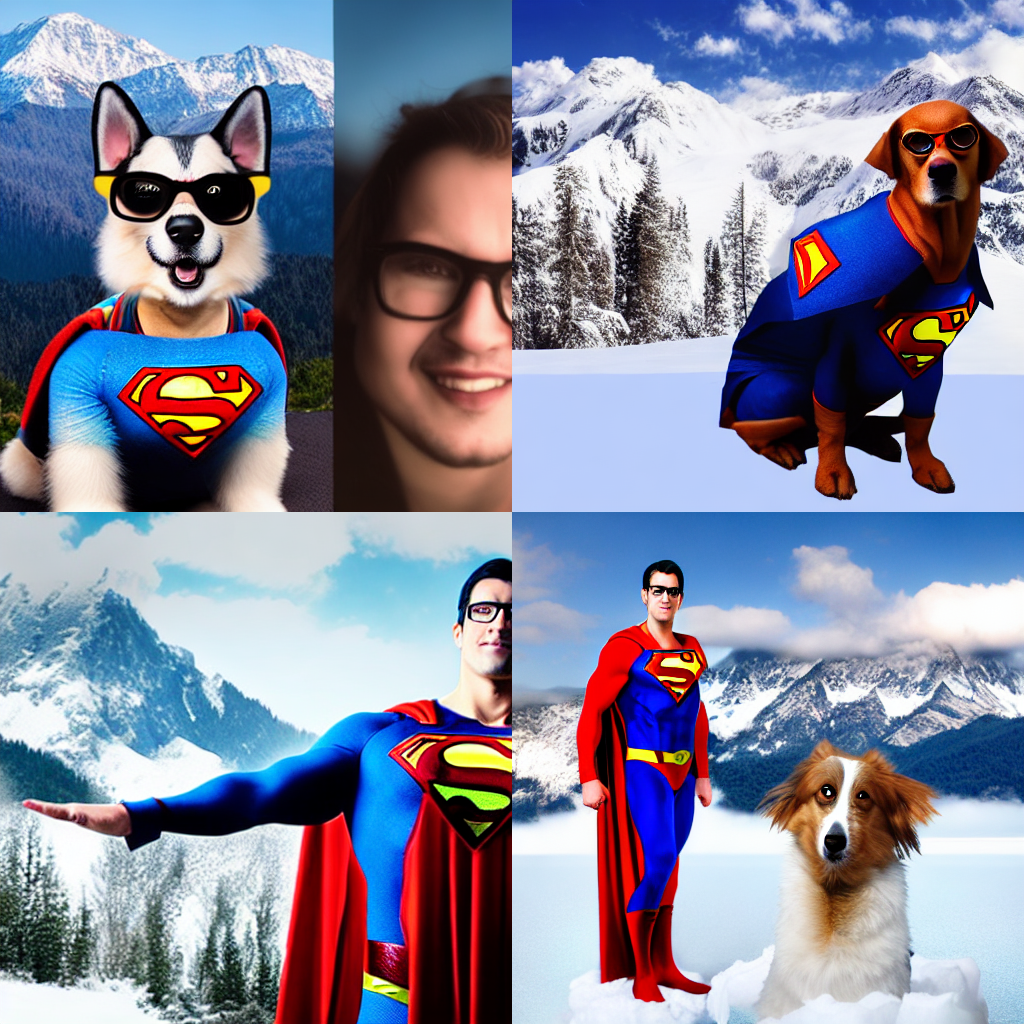

In [20]:
import math
from PIL import Image
from torch import autocast

def image_grid(imgs, cols):
    total = len(imgs)
    rows = math.ceil(total / cols)

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

all_images = []
for _ in range(num_batches):
    with autocast("cuda"):
        images = pipe([prompt] * num_samples,
                      height=height,
                      width=width,
                      num_inference_steps=num_inference_steps,
                      guidance_scale=guidance_scale).images
        all_images.extend(images)


grid = image_grid(all_images, num_columns)
grid

### Re-training the model

If you aren't satisfied with the inference outputs from the model, you can retrain it. Before you can do that, you might need to release the GPU memory.

In [ ]:
## Run this cell _only_ if you want to release the GPU memory.
import gc

pipe = None
gc.collect()
torch.cuda.empty_cache() # PyTorch thing

## Deploy the model to Vertex AI

You can host your Stable Diffusion 2.0 model on a Vertex AI endpoint where you can get inferences from it online. Uploading your model is a three step process: 

1. Create a custom TorchServe handler.
1. Upload the model artifacts onto Google Cloud Storage.
2. Create a Vertex AI model with the model artifacts and a prebuilt PyTorch container image.
3. Deploy the Vertex AI model onto an endpoint.

Before we can do that, though, we need to collect all of the model artifacts into a single place.

In [ ]:
!mkdir model_artifacts

### Create the custom TorchServe handler

The model deployed to Vertex AI uses [TorchServe](https://pytorch.org/serve/) to handle requests and return responses from the model. You must create a custom TorchServe handler to include in with the model artifacts uploaded to Vertex AI.

The handler file should be included in the directory with the other model artifacts.

In [2]:
%%writefile model_artifacts/handler.py

"""Customized handler for Stable Diffusion 2."""
import base64
import logging
from io import BytesIO

import torch
from diffusers import EulerDiscreteScheduler
from diffusers import StableDiffusionPipeline
from ts.torch_handler.base_handler import BaseHandler

logger = logging.getLogger(__name__)
model_id = 'stabilityai/stable-diffusion-2'


class ModelHandler(BaseHandler):

  def __init__(self):
    self.initialized = False
    self.map_location = None
    self.device = None
    self.use_gpu = True
    self.store_avg = True
    self.pipe = None

  def initialize(self, context):
    """Initializes the pipe."""
    properties = context.system_properties
    gpu_id = properties.get('gpu_id')

    self.map_location, self.device, self.use_gpu = \
      ('cuda', torch.device('cuda:' + str(gpu_id)),
       True) if torch.cuda.is_available() else \
        ('cpu', torch.device('cpu'), False)

    # Use the Euler scheduler here instead
    scheduler = EulerDiscreteScheduler.from_pretrained(model_id,
                                                       subfolder='scheduler')
    pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                                   scheduler=scheduler,
                                                   torch_dtype=torch.float16)
    pipe = pipe.to('cuda')
    # Uncomment the following line to reduce the GPU memory usage.
    # pipe.enable_attention_slicing()
    self.pipe = pipe

    self.initialized = True

  def preprocess(self, requests):
    """Noting to do here."""
    logger.info('requests: %s', requests)
    return requests

  def inference(self, preprocessed_data, *args, **kwargs):
    """Run the inference."""
    images = []
    for pd in preprocessed_data:
      prompt = pd['prompt']
      images.extend(self.pipe(prompt).images)
    return images

  def postprocess(self, output_batch):
    """Converts the images to base64 string."""
    postprocessed_data = []
    for op in output_batch:
      fp = BytesIO()
      op.save(fp, format='JPEG')
      postprocessed_data.append(base64.b64encode(fp.getvalue()).decode('utf-8'))
      fp.close()
    return postprocessed_data


Writing model_artifacts/handler.py


After creating the handler file, you must package the handler as a model archiver (MAR) file.

In [ ]:
!torch-model-archiver \
  -f \
  --model-name $MODEL_NAME \
  --version 1.0 \
  --handler model_artifacts/handler.py \
  --export-path model_artifacts

### Upload the model artifacts to Google Cloud Storage

Create a new folder in your Google Cloud Storage bucket to hold the model artifacts

In [ ]:
FULL_GCS_PATH = f"{BUCKET_URI}model_artifacts"

Next, upload the model archive file and your trained Stable Diffusion 2.0 model to the folder on Cloud Storage.

In [ ]:
!gsutil cp -r model_artifacts $BUCKET_URI
!gsutil cp -r $OUTPUT_DIR $FULL_GCS_PATH

### Create the Vertex AI model

Once you've uploaded the model artifacts into a Cloud Storage bucket, you can create a new Vertex AI model. This notebook uses the [Vertex AI SDK](https://cloud.google.com/vertex-ai/docs/start/use-vertex-ai-python-sdk) to create the model.

In [ ]:
CUSTOM_PREDICTOR_IMAGE_URI = f"us-docker.pkg.dev/vertex-ai/prediction/pytorch-gpu.1-12:latest"
APP_NAME = "my-stable-diffusion"
VERSION = 1
MODEL_DISPLAY_NAME = "stable_diffusion_2"
MODEL_DESCRIPTION = "stable_diffusion_2 container"
ENDPOINT_DISPLAY_NAME = f"{APP_NAME}-endpoint"

In [ ]:
from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_NAME)

In [ ]:
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    description=MODEL_DESCRIPTION,
    serving_container_image_uri=CUSTOM_PREDICTOR_IMAGE_URI,
    artifact_uri=FULL_GCS_PATH ,
)

model.wait()

print(model.display_name)
print(model.resource_name)

### Deploy the model to an endpoint

To get online preductions from your Stable Diffusion 2.0 model, you must [deploy it to a Vertex AI endpoint](https://cloud.google.com/vertex-ai/docs/predictions/overview). You can again use the Vertex AI SDK to create the endpoint and deploy your model.

In [ ]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

In [ ]:
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=model_display_name,
    machine_type="n1-standard-4",
    accelerator_type="NVIDIA_TESLA_T4",
    accelerator_count=1,
    traffic_percentage=100,
    sync=True,
)

## Get online predictions

Finally, with your Stable Diffusion 2.0 model deployed to a Vertex AI endpoint, you can now get online predictions from it. Using the Vertex AI SDK, you only need a few lines of code to get an inference.

In [ ]:
import base64
import json
from IPython import display

instances = [{ "prompt": "A dog with a baseball jersey." }]
response = endpoint.predict(instances=instances)

with open('img5.jpg', 'wb') as g:
    g.write(base64.b64decode(response.predictions[0]))
    
display.Image('img5.jpg')

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [1]:
import os

# Delete endpoint resource
endpoint.delete()

# Delete model resource
model.delete()

# Delete Cloud Storage objects that were created
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI